<a href="https://colab.research.google.com/github/greenjinu04/road-sign-colab-notebook/blob/main/Road_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install all fastbook dependencies and import required libraries
!pip install -Uqq fastbook
!pip install -Uqq unpackai

#library imports
from unpackai.utils import clean_error_img
from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 720 kB 5.4 MB/s 
     |████████████████████████████████| 46 kB 3.0 MB/s 
     |████████████████████████████████| 189 kB 38.9 MB/s 
     |████████████████████████████████| 1.2 MB 30.7 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
     |████████████████████████████████| 51 kB 271 kB/s 
     |████████████████████████████████| 58 kB 3.0 MB/s 
     |████████████████████████████████| 91 kB 7.5 MB/s 


In [ ]:
#install & import DuckDuckGoImageScraper specific packages
!pip install -q jmd_imagescraper
from jmd_imagescraper.imagecleaner import *
from pathlib import Path
from jmd_imagescraper.core import *

#download images
from google.colab import drive
drive.mount('/content/gdrive')
#path = Path('/content/gdrive/MyDrive/foldername')
path = Path('/content/gdrive/MyDrive/roadsign')

#number_images_to_download = 400
#duckduckgo_search(path, "LABEL1", "search term", max_results=number_images_to_download)
#duckduckgo_search(path, "LABEL2", "search term", max_results=number_images_to_download)
#duckduckgo_search(path, "round", "round road sign", max_results=100)
#duckduckgo_search(path, "triangle", "triangle road sign", max_results=100)
#duckduckgo_search(path, "square", "square road sign", max_results=100)
#duckduckgo_search(path, "oblique", "oblique square road sign", max_results=100)

Mounted at /content/gdrive


In [ ]:
#add images to dataset
!pip install -q jmd_imagescraper

from pathlib import Path
from jmd_imagescraper.core import *

path = Path().cwd()/"gdrive/MyDrive/roadsign"

In [ ]:
#data loaders
road = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = road.dataloaders(path)

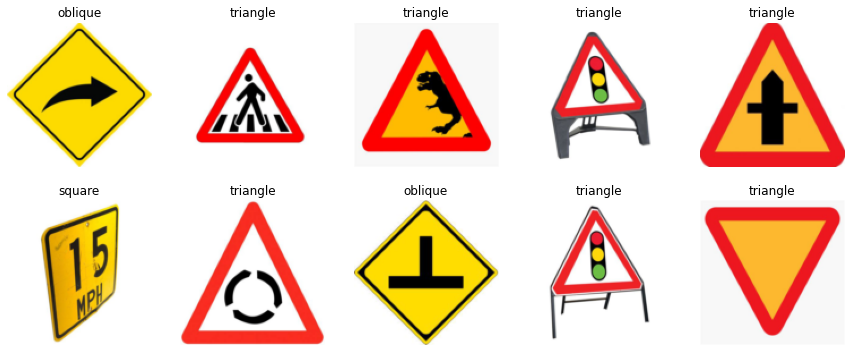

In [ ]:
#Lets have a look at our images by calling the show_batch method on our DataLoaders
road = road.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = road.dataloaders(path)
dls.valid.show_batch(max_n=10, nrows=2)

In [ ]:
#get rid of unsuitable images without leaving your notebook
from jmd_imagescraper.imagecleaner import *
display_image_cleaner(path)

HTML(value='<h2>No images left to display in this folder.</h2>', layout=Layout(visibility='hidden'))

GridBox(children=(VBox(children=(Image(value=b'', layout="Layout(width='150px')"), Button(description='Delete'…

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


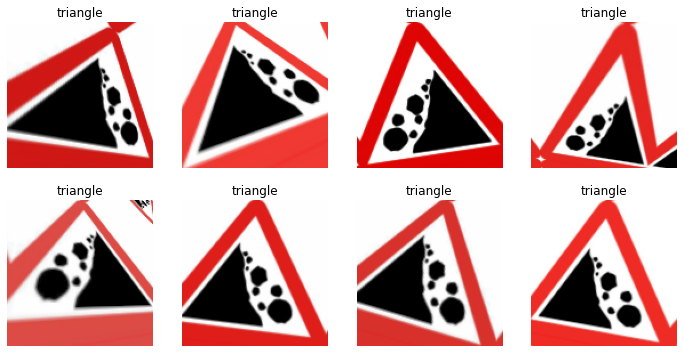

In [ ]:
#data augmentation
road = road.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = road.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
#train model
road = road.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = road.dataloaders(path)

learn = cnn_learner(dls, resnet18, metrics=[error_rate,accuracy])
learn.fine_tune(10)

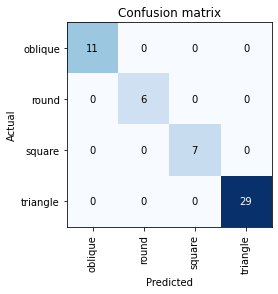

In [ ]:
#confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

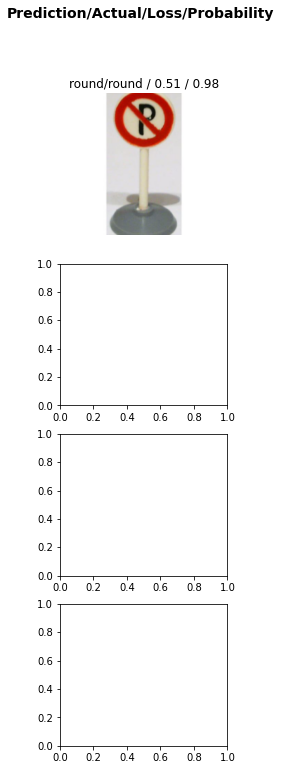

In [ ]:
#plot_top_losses shows us the images with the highest loss in our dataset
interp.plot_top_losses(4, nrows=4)

In [ ]:
#choose a class/category and the training versus validation set
#and view the highest-loss images (in order), along with menus to allow images
#to be selected for removal or relabeling:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#@title Delete or change classes of images as indicated in the `ImageClassifierCleaner`
for idx in cleaner.delete(): cleaner.fns[idx].unlink() #Delete
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat) #Change Class

In [ ]:
#create notebook
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

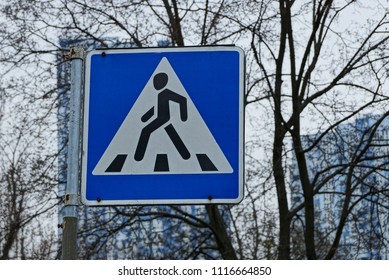

In [ ]:
img = PILImage.create(btn_upload.data[-1])
img

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: square; Probability: 0.9997')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Classify your sign!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
Learner.export(learn, fname='/content/gdrive/MyDrive/roadsignshaperecognition.pkl')